In [1]:
import barmuscomp.ae_utils as ae_utils
import barmuscomp.ae as ae
import barmuscomp.lra as lra
import barmuscomp.scripts.default_path as paths
import barmuscomp.scripts.overall_scripts as scr

import as_seg.CBM_algorithm as CBM
import as_seg.barwise_input as bi
import as_seg.data_manipulation as dm
import as_seg.autosimilarity_computation as as_comp
#import as_seg.barwise_input as bi
from barmuscomp.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

convolution_type = "14_bands"
autosimilarity_types = ["Cosine", "Covariance", "RBF"]
pen_function = "modulo8"
feature = "log_mel_grill"

compression_labels = ["PCA", "SSAE"]

dimensions_range = [8,16,24,32,40]

In [3]:
def return_results(references_segments, segments_in_time):
    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
    return [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

In [4]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 25, 105 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    else:
        ax.legend(labels=subaxis, loc='lower left')

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

# EUC

In [5]:
def compute_this_penalty_compression_euc(penalty_func, dim_patterns, autosimilarity_type = "cosine", feature = "nn_log_mel_grill", convolution_type = "14_bands"):
    idx_song_max = 101 # Should be 101 for all the dataset, other values should be for tests only
    songs_range = range(1,idx_song_max) 
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100
    lambda_penalty = 1

    results_songs_methods = math.inf * np.ones((len(songs_range), 2, len(dim_patterns), 2, 3)) # Songs, autosimilarity types, tol, metrics

    for idx_song, song_name in enumerate(songs_range):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)
        
        for idx_dc, dc in enumerate(dim_patterns):
            ### PCA
            #idx_method = 1
            try:
                Q_matrix_pca = np.load(f"{paths.path_data_persisted_rwc}/pca/pca_dim{dc}_song{song_name}_feature{feature}_hop{hop_length}_subdivbars{subdivision}.npy", allow_pickle = True)
            except FileNotFoundError:
                Q_matrix_pca = lra.pca_projection(barwise_TF_matrix, compression_dimension = dc)
                np.save(f"{paths.path_data_persisted_rwc}/pca/pca_dim{dc}_song{song_name}_feature{feature}_hop{hop_length}_subdivbars{subdivision}", Q_matrix_pca)

            autosimilarity_pca = as_comp.switch_autosimilarity(Q_matrix_pca, similarity_type = autosimilarity_type, normalise = True)
            segments_pca = CBM.compute_cbm(autosimilarity_pca, penalty_weight = lambda_penalty, penalty_func = penalty_func, convolution_type = convolution_type)[0]                
            segments_pca_in_time = dm.segments_from_bar_to_time(segments_pca, bars)
            results_songs_methods[idx_song, 0, idx_dc] = return_results(references_segments, segments_pca_in_time)


            ### AE
            #idx_method = 2
            Q_matrix_ae = np.load(f"{paths.path_data_persisted_rwc}/neural_nets/conv_4_16_k3_transk3_latentfc{dc}_song{song_name}_feature{feature}_hop{hop_length}_subdivbars{subdivision}_initkaiming_lr0.001_nepochs1000.npy", allow_pickle = True)
            autosimilarity_ae = as_comp.switch_autosimilarity(Q_matrix_ae, similarity_type = autosimilarity_type, normalise = True)
            segments_ae = CBM.compute_cbm(autosimilarity_ae, penalty_weight = lambda_penalty, penalty_func = penalty_func, convolution_type = convolution_type)[0]                
            segments_ae_in_time = dm.segments_from_bar_to_time(segments_ae, bars)
            results_songs_methods[idx_song, 1, idx_dc] = return_results(references_segments, segments_ae_in_time)

            
    odd_songs = range(0,idx_song_max - 1,2) # Weird, but shouldn't confuse indexes and number
    even_songs = range(1,idx_song_max - 1,2)
    to_return = -math.inf * np.ones((2, 2, 3))
    
    for idx_method in range(2):
        avg_odd_songs = np.mean(results_songs_methods[odd_songs, idx_method,:,0, 2], axis = 0) + np.mean(results_songs_methods[odd_songs, idx_method,:,1, 2], axis = 0)

        best_idx_odd = np.argmax(avg_odd_songs)
        print(f"Odd, method {compression_labels[idx_method]}, best dc: {dim_patterns[best_idx_odd]}")
        res_odd = math.inf * np.ones((2,3))
        for tol in range(2):
            for metric in range(3):
                res_odd[tol, metric] = np.mean(results_songs_methods[even_songs, idx_method, best_idx_odd, tol, metric])
    
        avg_even_songs = np.mean(results_songs_methods[even_songs, idx_method,:,0, 2], axis = 0) + np.mean(results_songs_methods[even_songs, idx_method,:,1, 2], axis = 0)
        best_idx_even = np.argmax(avg_even_songs)
        print(f"Even, method {compression_labels[idx_method]}, best dc: {dim_patterns[best_idx_even]}")
        res_even = math.inf * np.ones((2,3))
        for tol in range(2):
            for metric in range(3):
                res_even[tol, metric] = np.mean(results_songs_methods[odd_songs, idx_method, best_idx_even, tol, metric])
   
        to_return[idx_method] = np.mean(np.array([res_odd, res_even]), axis=0)
    
    return to_return

Kernel: 14_bands
Autosimilarity type: Cosine
Odd, method PCA, best dc: 24
Even, method PCA, best dc: 24
Odd, method SSAE, best dc: 16
Even, method SSAE, best dc: 32


,P0.5,R0.5,F0.5,P3,R3,F3
PCA,0.6186,0.6778,0.6417,0.7696,0.8473,0.8003
SSAE,0.5731,0.5660,0.5657,0.7875,0.7817,0.7797


Autosimilarity type: Covariance
Odd, method PCA, best dc: 24
Even, method PCA, best dc: 24
Odd, method SSAE, best dc: 40
Even, method SSAE, best dc: 24


,P0.5,R0.5,F0.5,P3,R3,F3
PCA,0.6186,0.6778,0.6417,0.7696,0.8473,0.8003
SSAE,0.6001,0.6990,0.6392,0.7363,0.8619,0.7864


Autosimilarity type: RBF
Odd, method PCA, best dc: 24
Even, method PCA, best dc: 8
Odd, method SSAE, best dc: 8
Even, method SSAE, best dc: 24


,P0.5,R0.5,F0.5,P3,R3,F3
PCA,0.6014,0.6446,0.6171,0.7736,0.8290,0.7942
SSAE,0.6044,0.6389,0.6163,0.7853,0.8303,0.8015


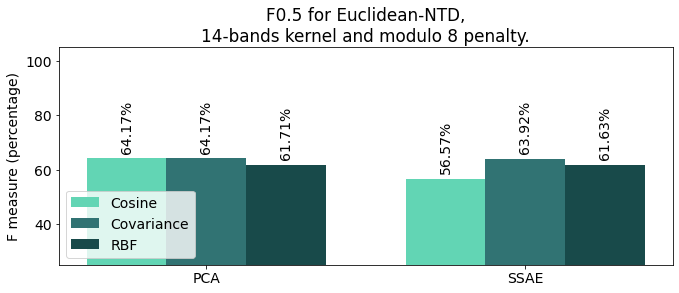

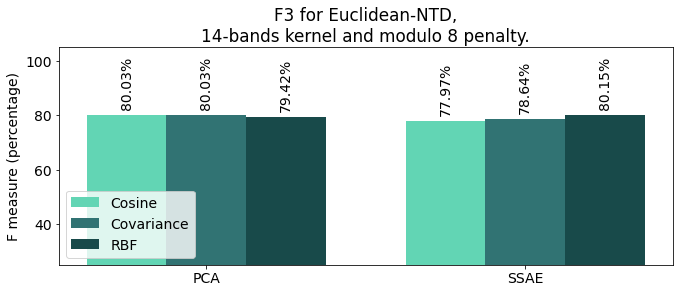

---------------
------------
------------
------------
------------


In [6]:
feature = "log_mel_grill"

print(f"Kernel: {convolution_type}")

res_avg_target = math.inf * np.ones((len(compression_labels), len(autosimilarity_types), 2, 3))

indexes = []
results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
for idx_as, autosimil_type in enumerate(autosimilarity_types):
    print(f"Autosimilarity type: {autosimil_type}")
    res = compute_this_penalty_compression_euc(pen_function, dimensions_range, autosimilarity_type = autosimil_type, feature = feature, convolution_type = convolution_type)
    for idx_line, line in enumerate(res):
        res_avg_target[idx_line, idx_as] = line
    dataframe = pd.DataFrame(res.reshape(res.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = compression_labels)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), compression_labels, autosimilarity_types, 0, title = f"F0.5 for Euclidean-NTD,\n14-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), compression_labels, autosimilarity_types, 1, title = f"F3 for Euclidean-NTD,\n14-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")